<a href="https://colab.research.google.com/github/vagmin27/DeepLearning/blob/main/BatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 3 : Batch Normalization Overview
 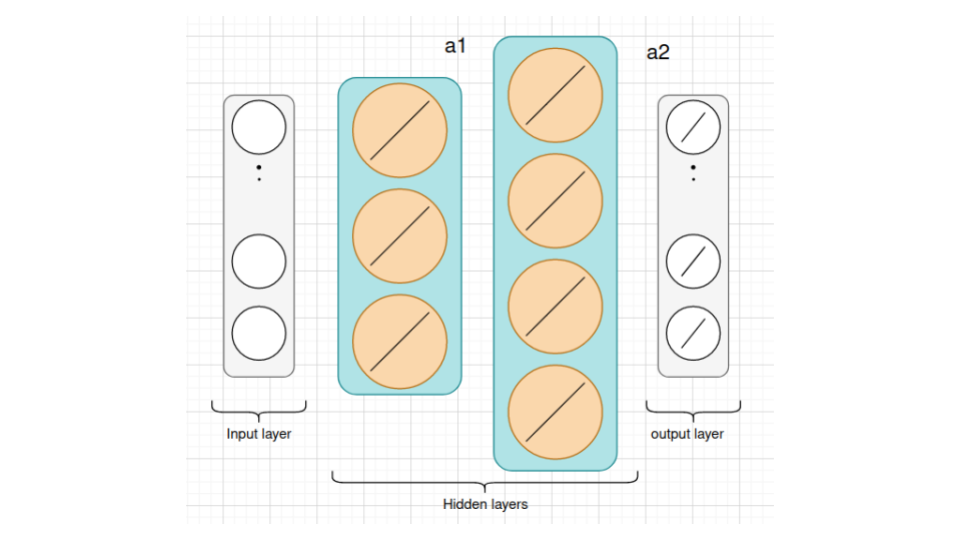

 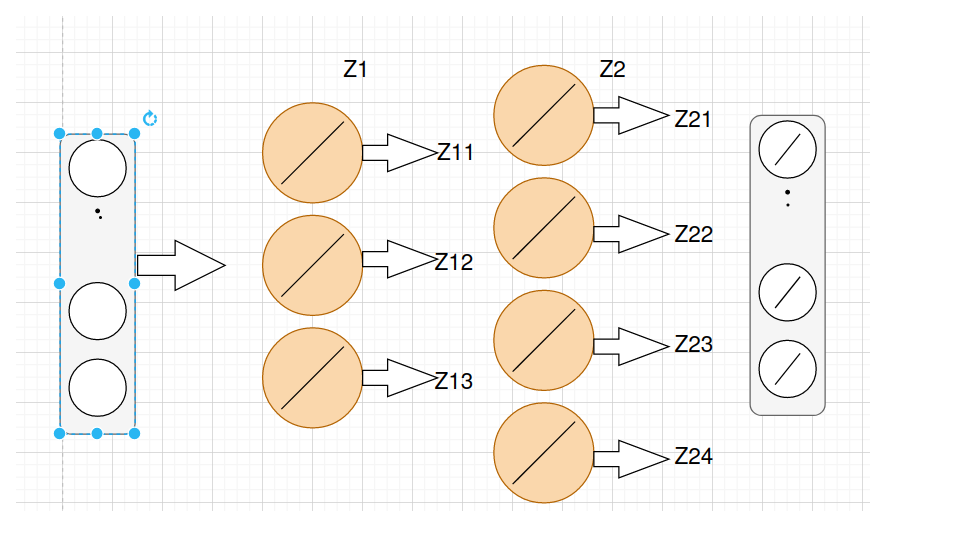


 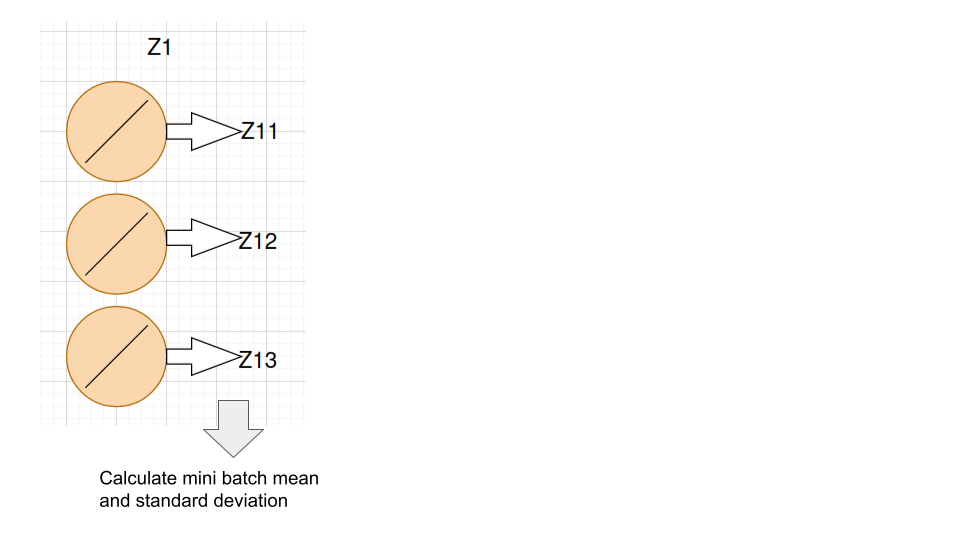
$\mu_{B,i}, σ_{B,i}^{2}$

now calculate : \
$\hat{Z}_{11} = \frac{Z_{11}-\mu_{B,1}}{(σ_{B,1}^{2}+ϵ)^{1/2}}$ \
$\hat{Z}_{12} = \frac{Z_{11}-\mu_{B,2}}{(σ_{B,2}^{2}+ϵ)^{1/2}}$ \
$\hat{Z}_{13} = \frac{Z_{11}-\mu_{B,3}}{(σ_{B,3}^{2}+ϵ)^{1/2}}$

$\tilde{Z}_{11} = \gamma_{11} × \hat{Z}_{11} + β_{11}$ \
$\tilde{Z}_{12} = \gamma_{12} × \hat{Z}_{12} + β_{12}$ \
$\tilde{Z}_{13} = \gamma_{13} × \hat{Z}_{13} + β_{13}$

Now pass them to the activation function.

### Define neural network with batch normalization

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(0)

# Neural Network Module with two hidden layers using Batch Normalization

class NetBatchNorm(nn.Module):

    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(NetBatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.bn1(self.linear1(x)))
        x = torch.sigmoid(self.bn2(self.linear2(x)))
        x = self.linear3(x)
        return x
# In general, Batch Norm layer is usually added before ReLU(as mentioned in the Batch Normalization paper).
# But there is no real standard being followed as to where to add a Batch Norm layer.
# You can experiment with different settings and you may find different performances for each setting.

    # Activations, to analyze results
    def activation(self, x):
        out = []
        z1 = self.bn1(self.linear1(x))
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.bn2(self.linear2(a1))
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out

# Neural Network Module with two hidden layers with out Batch Normalization
class Net(nn.Module):

    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)

    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x



    # function creates to analyze results what effect we get on output of the
    # activation function, after we apply batch normalization on the output of the linear layer and followed by the
    # the activation function.
    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out


In [3]:
# Define the function to train model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    loss_and_acc = {'training_loss':[], 'validation_accuracy':[]}

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_and_acc['training_loss'].append(loss.data.item())

        correct = 0
        for x, y in validation_loader:
            model.eval()
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()

        accuracy = 100 * (correct / len(validation_dataset))
        loss_and_acc['validation_accuracy'].append(accuracy)

    return loss_and_acc

### Training MNIST dataset wit the network containing batch normalization layer

In [4]:
# load the train dataset

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# load the train dataset

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create Data Loader for both train and validating

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)


# Create the criterion function

criterion = nn.CrossEntropyLoss()


# Set the parameters

input_dim = 28 * 28
hidden_dim = 100
output_dim = 10

# Create model, optimizer and train the model
model_norm  = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)
training_results_Norm=train(model_norm , criterion, train_loader, validation_loader, optimizer, epochs=5)


# Create model without Batch Normalization, optimizer and train the model
model = Net(input_dim, hidden_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


### Result Analysis

Compare the histograms of the activation for the first layer of the first sample, for both models.

In [ ]:
model.eval()
model_norm.eval()
out=model.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out[2],label='model with no batch normalization' )
out_norm=model_norm.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out_norm[2],label='model with normalization')
plt.xlabel("activation ")
plt.legend()
plt.show()

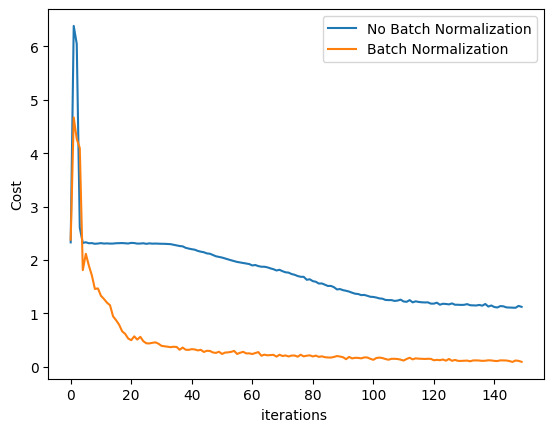

In [5]:
### training loss comparison
# Plot the diagram to show the loss

plt.plot(training_results['training_loss'], label='No Batch Normalization')
plt.plot(training_results_Norm['training_loss'], label='Batch Normalization')
plt.ylabel('Cost')
plt.xlabel('iterations ')
plt.legend()
plt.show()

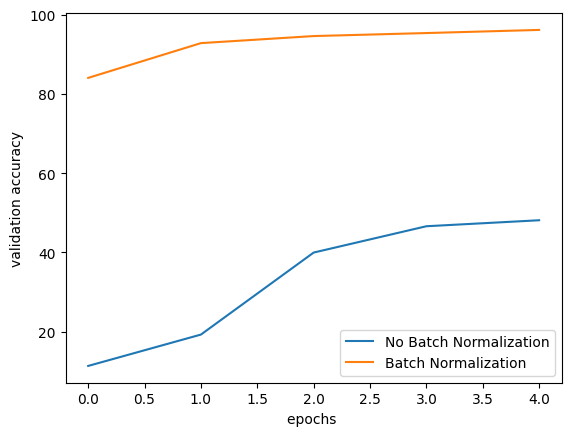

In [6]:
### Comparison of accuracy

plt.plot(training_results['validation_accuracy'],label='No Batch Normalization')
plt.plot(training_results_Norm['validation_accuracy'],label='Batch Normalization')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')
plt.legend()
plt.show()